In [1]:
%pylab inline
matplotlib.rcParams["image.cmap"] = "afmhot"
matplotlib.rcParams["image.interpolation"] = "none"
figsize(10,5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import clstm
import h5py

# LSTM + CTC Training on UW3 

Let's start by downloading the dataset.

In [5]:
!test -f uw3-dew.h5 || (curl http://www.tmbdev.net/ocrdata-hdf5/uw3-dew.h5.gz > uw3-dew.h5.gz && gunzip uw3-dew.h5.gz)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  393M  100  393M    0     0  72.0M      0  0:00:05  0:00:05 --:--:-- 81.2M


In HDF5 data files for CLSTM, row `t` represents the input vector at time step `t`. For MNIST, we scan through the original image left-to-right over time.

Transcripts are stored in a separate ragged array of integers; each integer represents a class that can be mapped to a Unicode codepoint using the `codec` array. Class 0 is special and used for skips in the CTC.

Image storage in HDF5 would have to be a rank 3 doubly ragged array, but HDF5 supports only rank 2 arrays. We therefore store image dimensions in a separate array.

[55 73 72 65 84 66 73 72 65  1 38 79 73]


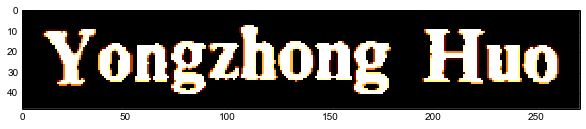

In [6]:
index = 5
h5 = h5py.File("uw3-dew.h5","r")
imshow(h5["images"][index].reshape(*h5["images_dims"][index]).T)
print h5["transcripts"][index]

All input vectors need to have the same length, so we just take that off the first vector in the dataset. The number of outputs can be taken from the codec.

In [7]:
ninput = int(h5["images_dims"][0][1])
noutput = len(h5["codec"])
print ninput,noutput

48 88


Let's create a small bidirectional LSTM network.

In [8]:
net = clstm.make_net_init("bidi","ninput=%d:nhidden=50:noutput=%d"%(ninput,noutput))
net.setLearningRate(1e-4,0.9)
print clstm.network_info(net)

.stacked: 0.000100 0.900000 48 88
.stacked.parallel: 0.000100 0.900000 48 100
.stacked.parallel.lstm: 0.000100 0.900000 48 50
.stacked.parallel.reversed: 0.000100 0.900000 48 50
.stacked.parallel.reversed.lstm: 0.000100 0.900000 48 50
.stacked.softmax: 0.000100 0.900000 100 88



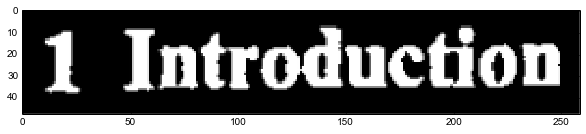

In [9]:
index = 22
xs = array(h5["images"][index].reshape(-1,48,1),'f')
transcript = h5["transcripts"][index]
imshow(xs.reshape(-1,48).T,cmap=cm.gray)

Forward propagation is quite simple: we take the input data and put it into the input sequence of the network, call the `forward` method, and take the result out of the output sequence.

Note that all sequences (including `xs`) in clstm are of rank 3, with indexes giving the time step, the feature dimension, and the batch index, in order.

The output from the network is a vector of posterior probabilities at each time step.

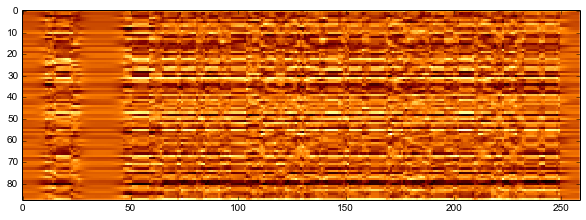

In [10]:
net.inputs.aset(xs)
net.forward()
pred = net.outputs.array()
imshow(pred.reshape(-1,noutput).T, interpolation='none')

Target arrays are similar to the output array but may have a different number of timesteps. They are aligned with the output using CTC.

In [11]:
def mktarget(transcript,noutput):
    N = len(transcript)
    target = zeros((2*N+1,noutput),'f')
    assert 0 not in transcript
    target[0,0] = 1
    for i,c in enumerate(transcript):
        target[2*i+1,c] = 1
        target[2*i+2,0] = 1
    return target

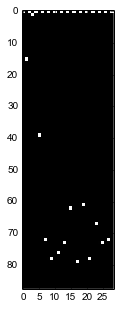

In [12]:
target = mktarget(transcript,noutput)
imshow(target.T)

The CTC alignment now combines the network output with the ground truth.

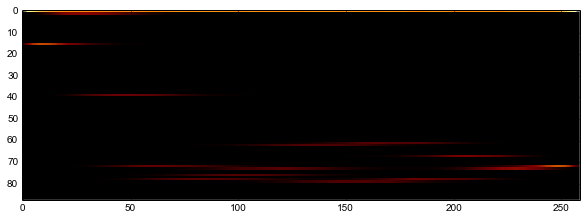

In [13]:
seq = clstm.Sequence()
seq.aset(target.reshape(-1,noutput,1))
aligned = clstm.Sequence()
clstm.seq_ctc_align(aligned,net.outputs,seq)
aligned = aligned.array()
imshow(aligned.reshape(-1,noutput).T, interpolation='none')

Next, we take the aligned output, subtract the actual output, set that as the output deltas, and the propagate the error backwards and update.

In [14]:
deltas = aligned - net.outputs.array()
net.d_outputs.aset(deltas)
net.backward()
net.update()

If we repeat these steps over and over again, we eventually end up with a trained network.

In [15]:
for i in range(10000):
    index = int(rand()*len(h5["images"]))
    xs = array(h5["images"][index].reshape(-1,ninput,1),'f')
    transcript = h5["transcripts"][index]
    net.inputs.aset(xs)
    net.forward()
    pred = net.outputs.array()
    target = mktarget(transcript,noutput)
    seq = clstm.Sequence()
    seq.aset(target.reshape(-1,noutput,1))
    aligned = clstm.Sequence()
    clstm.seq_ctc_align(aligned,net.outputs,seq)
    aligned = aligned.array()
    deltas = aligned - net.outputs.array()
    net.d_outputs.aset(deltas)
    net.backward()
    net.update()

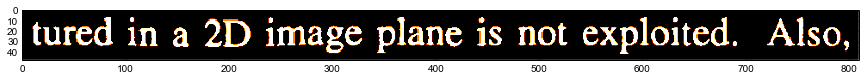

In [16]:
figsize(15,3)
imshow(xs.reshape(-1,ninput).T)

In [17]:
def log10max(a,eps=1e-3):
    return log10(maximum(a,eps))

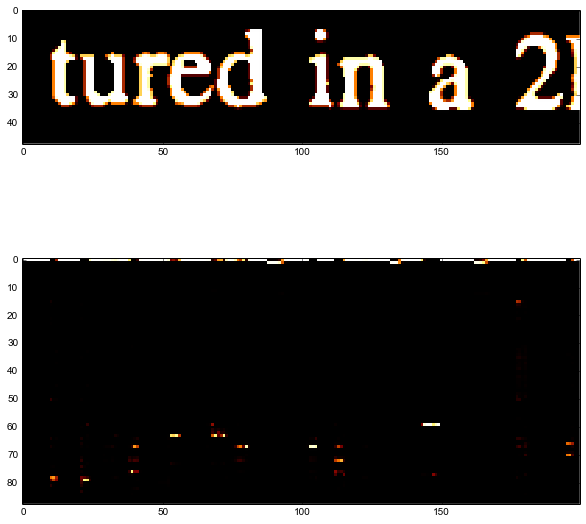

In [18]:
figsize(10,10)
subplot(211); imshow(xs.reshape(-1,ninput)[:200].T)
subplot(212); imshow(pred.reshape(-1,noutput)[:200].T)

Let's write a simple decoder.

In [19]:
classes = argmax(pred,axis=1)[:,0]
print classes[:100]

[ 0  0  0  0  0  0  0  0  0  0 78 78  0  0  0  0  0  0  0  0  0 78 79 79  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 76 67 67  0  0  0  0  0  0  0  0
  0  0  0 63 63 63  0  0  0  0  0  0  0  0  0  0  0  0 63 63  0  0 63  0  0
  0  0  0 67  0 67  0  0  0  0  0  0  0  1  1  1  1  1  0  0  0  0  0  0  0]


When we turn this back into a string using a really simple decoder, it doesn't come out too well, but we haven't trained that long anyway. In addition, this decoder is actually very simple

In [20]:
codes = classes[(classes!=0) & (roll(classes,1)==0)]
chars = [chr(h5["codec"][c]) for c in codes]
print "".join(chars)

ttreeeii in a 1l inage plane is iei enpleited. Also,


Let's wrap this up as a function:

In [21]:
def decode1(pred):
    classes = argmax(pred,axis=1)[:,0]
    codes = classes[(classes!=0) & (roll(classes,1)==0)]
    chars = [chr(h5["codec"][c]) for c in codes]
    return "".join(chars)
decode1(pred)

'ttreeeii in a 1l inage plane is iei enpleited. Also,'

Here is another idea for decoding: look for minima in the posterior of the epsilon class and then return characters at those locations:

In [22]:
from scipy.ndimage import filters
def decode2(pred,threshold=.5):
    eps = filters.gaussian_filter(pred[:,0,0],2,mode='nearest')
    loc = (roll(eps,-1)>eps) & (roll(eps,1)>eps) & (eps<threshold)
    classes = argmax(pred,axis=1)[:,0]
    codes = classes[loc]
    chars = [chr(h5["codec"][c]) for c in codes]
    return "".join(chars)    
decode2(pred)

'ui\x00 in a \x00 iiage plane is feueipleied. lse,'

It's often useful to look at this in the log domain. We see that the classifier still has considerable uncertainty.

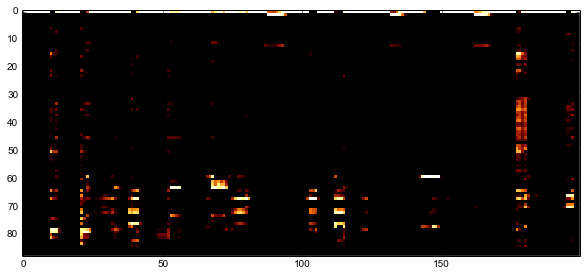

In [23]:
imshow(log10max(pred.reshape(-1,noutput)[:200].T))

The aligned output looks much cleaner.

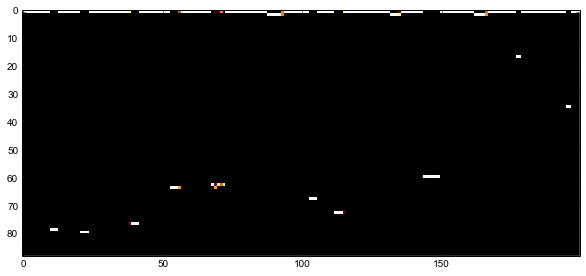

In [24]:
imshow(aligned.reshape(-1,noutput)[:200].T)

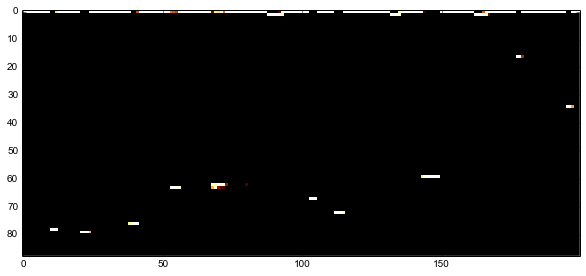

In [25]:
imshow(log10max(aligned.reshape(-1,noutput)[:200].T))

We can also decode the aligned outut directly.

In [26]:
print decode1(aligned)
print decode2(aligned,0.9)

turedd in a 2D image plane is not exploited. Also,
tured in a 2D image plane is not exploited. Also,


There is a better decoder in the CLSTM library.